# Model Evaluation and Visualization template

You can follow this python script to make some basic model evaluation exercises and the model field visualization

## 0. Import necessary python packages and import the prewritten functions.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os

# import hvplot.xarray
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# Part I. Model Evaluation

## 1. Load the data

We have simulated and observed data for SO2 (ug/m3), SO4 (ugS/m3), NH4 (ugN/m3), NO3 (ugN/m3), and PM2.5 (ug/m3) at three stations: Villum, Spitzbergen, and Alert.

In [2]:
# We totally have the following three stations available:
allstations = ['Villum','Spitzbergen','Alert']

# A function to get the data of one station
# Do not change below function, unless you know what you are doing.
def get_station_data(station):
    input_file = f'data/Arctic_aerosol_{station}.csv'

    df = pd.read_csv(input_file,header=0)
    # Convert date column to datetime format
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    return df

In [3]:
station = 'Alert'
df = get_station_data(station)
print(df.head(5))

            SO2_mod  SO2_mea  SO4_mod  SO4_mea  NH4_mod  NH4_mea  NO3_mod  \
date                                                                        
2007-01-01    0.405      NaN    0.080    0.288    0.024    0.072    0.037   
2007-01-08    1.700      NaN    0.241      NaN    0.045      NaN    0.070   
2007-01-15    0.973      NaN    0.250    0.208    0.037    0.033    0.051   
2007-01-22    0.330      NaN    0.115    0.230    0.034    0.044    0.058   
2007-01-29    0.408      NaN    0.116    0.253    0.036    0.056    0.043   

            NO3_mea  PM2.5_mod  
date                            
2007-01-01    0.026      1.510  
2007-01-08      NaN      2.416  
2007-01-15    0.018      3.583  
2007-01-22    0.027      1.545  
2007-01-29    0.048      4.677  


#### What do you observe from the data?

## 2. Plot the time series

In [4]:
# Function to plot the variable
# Do not change below function, unless you know what you are doing.
def plot_time_series(var,station,df=None,stddf=None):
    df = get_station_data(station) if df is None else df

    fig = go.Figure()
    
    
    if stddf is not None:
        # Add simulation line
        fig.add_trace(go.Scatter(y=df[f'{var}_mod'],x=df.index,name='model simulation',\
                    error_y=dict(type='data',array=stddf[f'{var}_mod'].values)))

        # Add observation line
        if f'{var}_mea' in df.columns:
            fig.add_trace(go.Scatter(y=df[f'{var}_mea'],x=df.index,name='measurement',\
                    error_y=dict(type='data',array=stddf[f'{var}_mod'].values)))

    else:
        # Add simulation line
        fig.add_trace(go.Scatter(y=df[f'{var}_mod'],x=df.index,name='model simulation'))

        # Add observation line
        if f'{var}_mea' in df.columns:
            fig.add_trace(go.Scatter(y=df[f'{var}_mea'],x=df.index,name='measurement'))


    # Title and legend
    fig.update_layout(title = f'{var} time series at {station}')
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ))
    fig.update_layout(showlegend=True) 
    fig.show()


In [5]:
chemical,station = 'SO4','Villum'   # Choose from 'SO2', 'SO4', 'NH4', 'NO3', and 'PM2.5' for chemical, 
                                    # and 'Villum','Spitzbergen','Alert' for station
plot_time_series(chemical,station)

#### Please change the chemical and the station to take a look at the time series of different chemicals and different stations.

Tips:

1. You can copy the cell down when you want to look at a new chemical or new location, so that you can keep all figures.

2. You can download the plots you want for exercise report, and maybe for your final report. Download option is on the top-right option panel of the figure.

## 3. Interannual variation (annual mean)

In [6]:
# Look at annua
chemical,station = 'SO4','Villum'   # Choose from 'SO2', 'SO4', 'NH4', 'NO3', and 'PM2.5' for chemical, 
                                    # and 'Villum','Spitzbergen','Alert' for station
df = get_station_data(station)
annual_df = df.groupby(pd.Grouper(freq='1Y')).mean()

# Without standard deviation
plot_time_series(chemical,station,df=annual_df)

In [7]:
annual_std_df = df.groupby(pd.Grouper(freq='1Y')).std()

# With standard deviation
plot_time_series(chemical,station,df=annual_df,stddf=annual_std_df)

#### What do you found from the interannual variations? Are they showing the same characteristics for different chemicals or different stations?

## 4. Seasonal cycle

In [8]:
chemical,station = 'SO4','Villum'   # Choose from 'SO2', 'SO4', 'NH4', 'NO3', and 'PM2.5' for chemical, 
                                    # and 'Villum','Spitzbergen','Alert' for station
df['date'] = pd.to_datetime(df.index)
seasonal_df = df.groupby(df.date.dt.month).mean()

plot_time_series(chemical,station,df=seasonal_df)

In [9]:
seasonal_std_df = df.groupby(df.date.dt.month).std()

# Add standard deviation
plot_time_series(chemical,station,df=seasonal_df,stddf=seasonal_std_df)

#### How would you describe their seasonal cycle? Are they showing the same characteristics for different chemicals or different stations?

## 5. Evaluations

### 1-1 Scatter plot

In [10]:
# Function to plot the scatter plot
# Do not change below function, unless you know what you are doing.
def plot_scatter(var,station,df=None):
    df = get_station_data(station) if df is None else df
    if f'{var}_mea' not in df.columns:
        print(f'No measurement of {var} available')
        return
    
    vmin,vmax = 0,max(df[f'{var}_mea'].max(),df[f'{var}_mod'].max())*1.02
    fig = px.scatter(df, x=f'{var}_mea', y=f'{var}_mod', \
                marginal_x='histogram', marginal_y='histogram',\
                trendline="ols",\
                width=800,height=800)
    fig.update_traces(histnorm='probability', selector={'type':'histogram'})

    fig.update_layout(title = f'{var} model simulation vs measurement at {station}')
    fig.update_layout(yaxis=dict(range=[vmin,vmax]))
    fig.update_layout(xaxis=dict(range=[vmin,vmax]))
    fig.show()

    results = px.get_trendline_results(fig)
    print(results.px_fit_results.iloc[0].summary())

In [11]:
chemical,station = 'SO4','Villum'   # Choose from 'SO2', 'SO4', 'NH4', 'NO3', and 'PM2.5' for chemical, 
                                    # and 'Villum','Spitzbergen','Alert' for station
plot_scatter(chemical,station)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     416.8
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           9.39e-70
Time:                        13:11:59   Log-Likelihood:                 892.36
No. Observations:                 565   AIC:                            -1781.
Df Residuals:                     563   BIC:                            -1772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0405      0.003     14.330      0.0

### Model residuals: Model simulated values minus observed values

In [12]:
# Function to plot the scatter plot
# Do not change below function, unless you know what you are doing.
def plot_residual(var,station,df=None):
    df = get_station_data(station) if df is None else df
    if f'{var}_mea' not in df.columns:
        print(f'No measurement of {var} available')
        return
    
    vmin,vmax = 0,max(df[f'{var}_mea'].max(),df[f'{var}_mod'].max())*1.02
    df['residual'] = df[f'{var}_mod'] - df[f'{var}_mea']

    fig = px.scatter(df, x=f'{var}_mea', y='residual',
                marginal_y='violin', trendline='ols',
                width=1000,height=800)

    fig.update_layout(title = f'{var} model simulation vs measurement at {station}')
    # fig.update_layout(yaxis=dict(range=[vmin,vmax]))
    # fig.update_layout(xaxis=dict(range=[vmin,vmax]))
    fig.show()


In [13]:
chemical,station = 'SO4','Villum'   # Choose from 'SO2', 'SO4', 'NH4', 'NO3', and 'PM2.5' for chemical, 
                                    # and 'Villum','Spitzbergen','Alert' for station
plot_residual(chemical,station)

### Evaluation metrics

#### Calculate the evaluation metrics:
mean, standard deviation (std), Mean Bias (MB), Root Mean Square Error (RMSE), Normalized Mean Bias (NMB), and correlation coefficient (corr) 

In [14]:
from functions import calc_metrics

# Function to calculate all metrics
def calculate_all_metrics():
    metrics = ['mean_DEHM','mean_OBS','std_DEHM','std_OBS','MB','RMSE','NMB','corr']

    # Initialize output
    outdict = {'station':[],'chemical':[]}
    for imtr in metrics:
        outdict[imtr] = []

    # Calculate the metrics
    for station in allstations:
        for chemical in ['SO2','SO4','NH4','NO3']:
            df = get_station_data(station)
            valid_df = df[[f'{chemical}_mea',f'{chemical}_mod']].dropna()
            sim,obs = valid_df[f'{chemical}_mod'], valid_df[f'{chemical}_mea']
            mdic = calc_metrics(sim,obs)
            outdict['station'].append(station)
            outdict['chemical'].append(chemical)
            for imtr in metrics:
                outdict[imtr].append(mdic[imtr])
    
    out_df = pd.DataFrame.from_dict(outdict)
    return out_df

In [15]:
# Calculate the metrics for each chemical
metrics_df = calculate_all_metrics()
print(metrics_df)

        station chemical  mean_DEHM  mean_OBS  std_DEHM   std_OBS        MB  \
0        Villum      SO2   0.147534  0.060275  0.312910  0.137709  0.087258   
1        Villum      SO4   0.078929  0.120083  0.065790  0.133922 -0.041154   
2        Villum      NH4   0.035463  0.033664  0.023406  0.034369  0.001799   
3        Villum      NO3   0.038100  0.015066  0.020026  0.010901  0.023033   
4   Spitzbergen      SO2   0.187245  0.086028  0.309027  0.129412  0.101217   
5   Spitzbergen      SO4   0.108608  0.108507  0.082223  0.099923  0.000100   
6   Spitzbergen      NH4   0.042921  0.058095  0.029435  0.094779 -0.015174   
7   Spitzbergen      NO3   0.039901  0.058637  0.024530  0.106671 -0.018736   
8         Alert      SO2        NaN       NaN       NaN       NaN       NaN   
9         Alert      SO4   0.088145  0.151270  0.074626  0.135013 -0.063125   
10        Alert      NH4   0.036740  0.039395  0.022398  0.033536 -0.002654   
11        Alert      NO3   0.039991  0.013614  0.021

In [16]:
# Save the metrics table
output_file = 'All_metrics.csv'
metrics_df.to_csv(output_file)

#### Take a look at these metrics, do you know the meaning of each of them? (Google is always a good friend)

#### Based on these statistic values of evaluation metrics. How would you describe the model?

# Part II. DEHM (Danish Eulerian Hemispheric Model) 

Take a look at the netcdf dataset, what components are included, how many dimensions are there? What are the resolutions?

In [17]:
from functions import aerosol_dehm

dehm = aerosol_dehm()
ds = dehm.ds.load()
print(ds)

<xarray.Dataset>
Dimensions:      (x: 300, y: 300)
Coordinates:
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    z            int64 0
Data variables:
    SO2_ugSm-3   (x, y) float64 0.4712 0.4702 0.4705 ... 0.1892 0.189 0.189
    NH4_ugNm-3   (x, y) float64 1.692 1.697 1.697 1.333 ... 0.5821 0.5822 0.5821
    SO4_ugSm-3   (x, y) float64 0.4039 0.4038 0.4037 ... 0.493 0.4929 0.4928
    tSO4_ugSm-3  (x, y) float64 0.6997 0.699 0.699 ... 0.5609 0.5609 0.5607
    PM2.5_ugm-3  (x, y) float64 9.284 9.293 9.301 7.807 ... 4.516 4.517 4.516
    PM10_ugm-3   (x, y) float64 9.927 9.922 9.922 8.229 ... 4.843 4.843 4.842
    SIA_ugm-3    (x, y) float64 6.193 6.2 6.199 5.138 ... 3.056 3.201 3.201 3.2
    lat          (x, y) float64 40.78 40.92 41.06 41.2 ... 43.63 43.48 43.34
    lon          (x, y) float64 -77.0 -77.19 -77.37 -77.56 ... 102.6 102.8 103.0


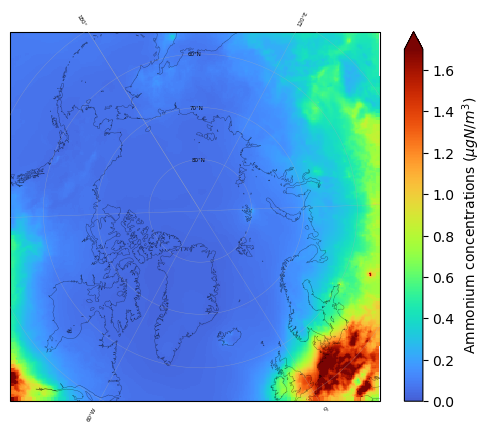

In [21]:
%matplotlib inline
chemical = 'NH4'   # Select from "SO4", "NH4", and "PM2.5"
fig = dehm.plot_annual_map(chemical) # You can also set vmin, and vmax to change the colorscale, such as:
                                     # fig = dehm.plot_annual_map(var,vmin=0,vmax=1)
fig.show()

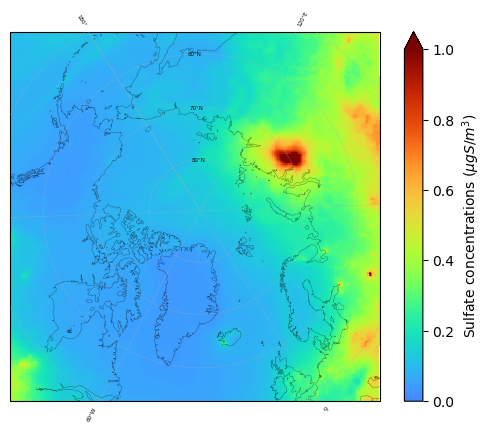

In [19]:
%matplotlib inline
chemical = 'SO4'   # Select from "SO4", "NH4", and "PM2.5"
fig = dehm.plot_annual_map(chemical) # You can also set vmin, and vmax to change the colorscale, such as:
                                     # fig = dehm.plot_annual_map(var,vmin=0,vmax=1)
fig.show()

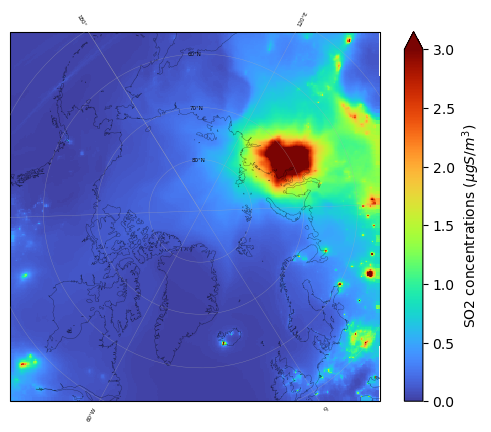

In [22]:
%matplotlib inline
chemical = 'SO2'   # Select from "SO4", "NH4", and "PM2.5"
fig = dehm.plot_annual_map(chemical) # You can also set vmin, and vmax to change the colorscale, such as:
                                     # fig = dehm.plot_annual_map(var,vmin=0,vmax=1)
fig.show()